# Graduation Rates at PelotonU
This project hypothesizes that the graduation rate for the Hybrid College nonprofit organization, PelotonU, follows a Poisson distribution.

Let's start with the pre-reqs

In [434]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

Let's define this quick helper function.

In [435]:
def getMonth(row):
    date = datetime.strptime(row['PU Tenure Completed Date'], '%m/%d/%Y')
    return date.month

def getYear(row):
    date = datetime.strptime(row['PU Tenure Completed Date'], '%m/%d/%Y')
    return date.year

def getMonthYear(row):
    date = datetime.strptime(row['PU Tenure Completed Date'], '%m/%d/%Y')
    return str (date.month)+"-"+str (date.year)

Now let's download our spreadsheet data

In [436]:
df = pd.read_excel(r'../grad_dates_by_student.xlsx', sheet_name='Sheet1')
total_graduations = len(df.index)
first = df['PU Tenure Completed Date'].iloc[0]
last = df['PU Tenure Completed Date'].iloc[total_graduations-1]
print(last)
df['month'] = df.apply(lambda row: getMonth(row), axis=1)
df['year'] = df.apply(lambda row: getYear(row), axis=1)
df['month-year']= df.apply(lambda row: getMonthYear(row), axis=1)
print(df)


4/24/2022
   PU Tenure Completed Date  month  year month-year
0                10/10/2017     10  2017    10-2017
1                10/20/2017     10  2017    10-2017
2                12/21/2017     12  2017    12-2017
3                 4/30/2018      4  2018     4-2018
4                 8/31/2018      8  2018     8-2018
..                      ...    ...   ...        ...
74                1/20/2022      1  2022     1-2022
75                2/16/2022      2  2022     2-2022
76                 3/1/2022      3  2022     3-2022
77                4/24/2022      4  2022     4-2022
78                4/24/2022      4  2022     4-2022

[79 rows x 4 columns]


Let's get the frequency distribution of the data.

In [437]:
agg_df = pd.DataFrame()
agg_df = df.groupby(['month-year']).count().reset_index()
agg_df.drop('PU Tenure Completed Date', inplace=True, axis=1)
agg_df.drop('month', inplace=True, axis=1)
agg_df.rename(columns={"year":"count"}, inplace=True)
print(agg_df)
print(len(agg_df))
warnings.filterwarnings("ignore")

   month-year  count
0      1-2019      1
1      1-2020      3
2      1-2022      1
3     10-2017      2
4     10-2020      1
5     11-2018      1
6     11-2019      1
7     11-2020      2
8     12-2017      1
9     12-2018      4
10    12-2019      1
11    12-2020      2
12    12-2021      5
13     2-2019      1
14     2-2020      1
15     2-2021      6
16     2-2022      1
17     3-2019      1
18     3-2020      1
19     3-2021      2
20     3-2022      1
21     4-2018      1
22     4-2019      2
23     4-2020      2
24     4-2021      7
25     4-2022      2
26     5-2020      3
27     5-2021      1
28     6-2020      3
29     6-2021      1
30     7-2019      3
31     8-2018      2
32     8-2019      2
33     8-2021      5
34     9-2018      2
35     9-2019      1
36     9-2020      2
37     9-2021      1
38


Our data doesn't account for months with no grads. How many months are those?

In [438]:
earliestGradDate = datetime.strptime(first, '%m/%d/%Y')
latestGradDate = datetime.strptime(last, '%m/%d/%Y')
elapsedDates = relativedelta(latestGradDate, earliestGradDate)
elapsedMonths = elapsedDates.months+elapsedDates.years*12
poiss_lambda = total_graduations/elapsedMonths
count_monthsNoGrads = elapsedMonths-len(agg_df)
print(count_monthsNoGrads, "months total with no grads.")

16 months total with no grads.


Great! Now let's append these months to our frequency distribution dataframe.

In [439]:
df_agg = pd.DataFrame()
df_agg = agg_df
counter = 0
while(counter < count_monthsNoGrads):
    df_agg = df_agg.append({'month-year': '0-0', 'count':0}, ignore_index=True)
    counter = counter+1

print(df_agg)

   month-year  count
0      1-2019      1
1      1-2020      3
2      1-2022      1
3     10-2017      2
4     10-2020      1
5     11-2018      1
6     11-2019      1
7     11-2020      2
8     12-2017      1
9     12-2018      4
10    12-2019      1
11    12-2020      2
12    12-2021      5
13     2-2019      1
14     2-2020      1
15     2-2021      6
16     2-2022      1
17     3-2019      1
18     3-2020      1
19     3-2021      2
20     3-2022      1
21     4-2018      1
22     4-2019      2
23     4-2020      2
24     4-2021      7
25     4-2022      2
26     5-2020      3
27     5-2021      1
28     6-2020      3
29     6-2021      1
30     7-2019      3
31     8-2018      2
32     8-2019      2
33     8-2021      5
34     9-2018      2
35     9-2019      1
36     9-2020      2
37     9-2021      1
38        0-0      0
39        0-0      0
40        0-0      0
41        0-0      0
42        0-0      0
43        0-0      0
44        0-0      0
45        0-0      0
46        0-0

From here, we can display the frequency distribution in a table.

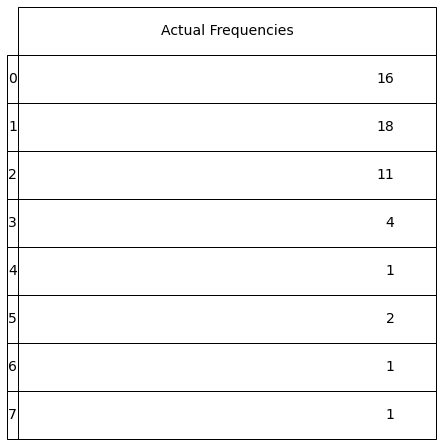

In [440]:
frequencies = pd.DataFrame({'Actual Frequencies' : df_agg.groupby(["count"]).size()})
frequencies = frequencies.sort_values(by=["count", "Actual Frequencies"])


fig, ax = plt.subplots()
fig.patch.set_visible(True)

#create table
table = ax.table(cellText=frequencies.values, rowLabels=frequencies.index, colLabels=frequencies.columns, loc='center')

#display table
table.set_fontsize(14)
table.scale(1,4)
ax.axis('off')
plt.show()


We can also display this frequency distribution on a histogram.

(array([16., 18., 11.,  4.,  1.,  2.,  1.,  1.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <BarContainer object of 8 artists>)

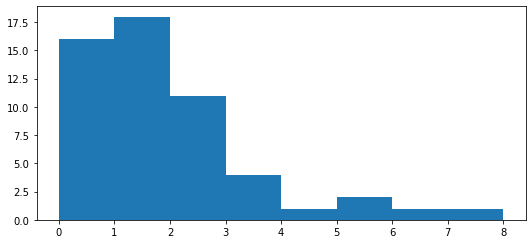

In [441]:
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8])

We can create a poisson pdf diagram with a λ from our data and overlay it above our histogram to see the similarities.

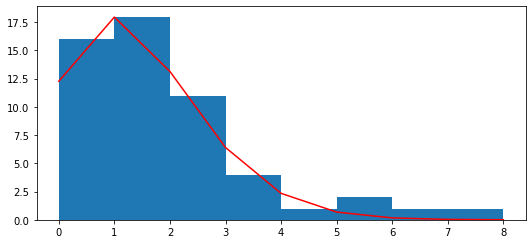

In [442]:
x = np.arange(0, 9, 1)
y = poisson.pmf(x, mu=poiss_lambda, loc=0)*53
plt.hist(df_agg['count'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.plot( x, y, 'r-' )
plt.show()
